<a href="https://colab.research.google.com/github/redhatpanda/Cyber-Security-Project-6th-Sem/blob/master/CICIDS-Classification-Final-Project-6thSem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cyber Security Project - 6th Semester 

## Problem Statement : Network Attack Prediction using different classifiers. Select the CICIDS 2017 dataset and perform a binary classification of predicting attack types using the feature set. Also use different AI/ML models for classification and compare the performance of each classifier.

## Group Members:
### Disha Chakraborty (B-141)
### Swapnanil Ray (B-147)
### Surya Sekhar Datta (B-150)
### Manosij Sur Chowdhury (B-135)
### Battula Smriti Rani (B-159)

# Importing the libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import seaborn as sns
import sklearn
import imblearn
import matplotlib.pyplot as plt
import time
import sklearn.metrics as m
import xgboost as xgb

In [ ]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Importing the dataset

In [ ]:
cols = [' Bwd Packet Length Std',' PSH Flag Count',' min_seg_size_forward',' Min Packet Length',' ACK Flag Count',' Bwd Packet Length Min',' Fwd IAT Std','Init_Win_bytes_forward',' Flow IAT Max',' Bwd Packets/s',' URG Flag Count','Bwd IAT Total',' Label']
df1=pd.read_csv("Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv", usecols = cols)#,nrows = 50000
df2=pd.read_csv("Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv", usecols = cols)
df3=pd.read_csv("Friday-WorkingHours-Morning.pcap_ISCX.csv", usecols = cols)
df5=pd.read_csv("Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv", usecols = cols)
df6=pd.read_csv("Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv", usecols = cols)

# df4, df7 and df8 are being left out as they only have the benign samples


# Data Preprocessing

In [ ]:
df = pd.concat([df1,df2])
del df1,df2
df = pd.concat([df,df3])
del df3
df = pd.concat([df,df5])
del df5
df = pd.concat([df,df6])
del df6

data = df.copy()

for column in data.columns:
    if data[column].dtype == np.int64:
        maxVal = data[column].max()
        if maxVal < 120:
            data[column] = data[column].astype(np.int8)
        elif maxVal < 32767:
            data[column] = data[column].astype(np.int16)
        else:
            data[column] = data[column].astype(np.int32)
            
    if data[column].dtype == np.float64:
        maxVal = data[column].max()
        minVal = data[data[column]>0][column]
        if maxVal < 120 and minVal>0.01 :
            data[column] = data[column].astype(np.float16)
        else:
            data[column] = data[column].astype(np.float32)
            
            

attackType = data[' Label'].unique()
data[' Label'] = data[' Label'].astype('category')
data[' Label'] = data[' Label'].astype("category").cat.codes

In [ ]:
y = data[' Label'].copy()
X = data.drop([' Label'],axis=1)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler('majority')
X_rus, y_rus = rus.fit_resample(X, y)

In [ ]:
y_rus.value_counts()

In [ ]:
df = X_rus
df[' Label'] = y_rus
minor = pd.DataFrame(df[(df[' Label']!=4) & (df[' Label']!=2)])
major = pd.DataFrame(df[(df[' Label']==4) | (df[' Label']==2)])
minor[' Label'].value_counts()

1    1966
5    1507
7     652
3      36
0      21
6      21
Name:  Label, dtype: int64

In [ ]:
from imblearn.over_sampling import SMOTE
y_rus_ =  minor[' Label']
X_rus_ =  minor.drop([' Label'],axis=1)
strategy = {1:2000, 5:1600, 7:800, 3:300, 6:200, 0:200}
sm = SMOTE(sampling_strategy=strategy)
X_sm, y_sm = sm.fit_resample(X_rus_, y_rus_)
X_min,y_min = X_sm, y_sm 

In [ ]:
major[' Label'].value_counts()

4    158930
2    128027
Name:  Label, dtype: int64

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
y_rus_ =  major[' Label']
X_rus_ =  major.drop([' Label'],axis=1)
strategy = {4:10000, 2:6000}
tom = RandomUnderSampler(sampling_strategy=strategy)
X_tom, y_tom = tom.fit_resample(X_rus_, y_rus_)
y_tom.value_counts()

4    10000
2     6000
Name:  Label, dtype: int64

In [ ]:
X_maj,y_maj = X_tom, y_tom
X,y = pd.concat([X_maj,X_min]), pd.concat([y_maj,y_min])
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21100 entries, 0 to 5099
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0    Bwd Packet Length Min  21100 non-null  int16  
 1    Bwd Packet Length Std  21100 non-null  float32
 2    Flow IAT Max           21100 non-null  int32  
 3    Fwd IAT Std            21100 non-null  float32
 4   Bwd IAT Total           21100 non-null  int32  
 5    Bwd Packets/s          21100 non-null  float32
 6    Min Packet Length      21100 non-null  int16  
 7    PSH Flag Count         21100 non-null  int8   
 8    ACK Flag Count         21100 non-null  int8   
 9    URG Flag Count         21100 non-null  int8   
 10  Init_Win_bytes_forward  21100 non-null  int32  
 11   min_seg_size_forward   21100 non-null  int8   
dtypes: float32(3), int16(2), int32(3), int8(4)
memory usage: 824.2 KB


# Spillting the dataset into the Training set and Test set & Initialising different classifiers

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# extract numerical attributes and scale it to have zero mean and unit variance  
cols = X.select_dtypes(include=['float32','float16','int32','int16','int8']).columns
train_X = scaler.fit_transform(X.select_dtypes(include=['float32','float16','int32','int16','int8']))



from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(train_X,y,train_size=0.70, random_state=2)


from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB 
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Train Random Forest
RFC_Classifier = RandomForestClassifier(max_depth=40)
RFC_Classifier.fit(X_train, Y_train)
print ('RF Classifier run')

# Train SVC
SVM_Classifier = SVC()
SVM_Classifier.fit(X_train, Y_train)
print ('SV Classifier run')

# Train Decision Tree Model
DTC_Classifier = tree.DecisionTreeClassifier(criterion='gini', max_depth=33, random_state=20, max_features=12, splitter='random')
DTC_Classifier.fit(X_train, Y_train)
print ('DTC Classifier run')

# Train KNeighborsClassifier Model
KNN_Classifier = KNeighborsClassifier(n_jobs=-1)
KNN_Classifier.fit(X_train, Y_train)
print ('KNN Classifier run')

# Train LogisticRegression Model
LGR_Classifier = LogisticRegression(n_jobs=-1, random_state=0, max_iter=5000)
LGR_Classifier.fit(X_train, Y_train)
print ('LGR Classifier run')

# Train Gaussian Naive Baye Model
BNB_Classifier = BernoulliNB()
BNB_Classifier.fit(X_train, Y_train)
print ('BNB Classifier run')


RF Classifier run
SV Classifier run
DTC Classifier run
KNN Classifier run
LGR Classifier run
BNB Classifier run


# Model Evaluation


============================== Random Forest Classifier Model Evaluation ==============================

Cross Validation Mean Score:
 0.9610673048165823

Model Accuracy:
 0.9942447017401314

Confusion matrix:
 [[ 140    0    0    0    0    0    0    0]
 [   0 1359    0    0    0    0    0    0]
 [   0    0 4232    0    0    0    0    0]
 [   0    0    0  197    0    0    0    0]
 [   0    0    0    0 7034    0    0    0]
 [   0    0    0    0    0 1105    0    0]
 [   0    0    0    0    0    1  141    0]
 [   0    0    0    0    0   84    0  476]]

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       140
           1       1.00      1.00      1.00      1359
           2       1.00      1.00      1.00      4232
           3       1.00      1.00      1.00       197
           4       1.00      1.00      1.00      7034
           5       0.93      1.00      0.96      1105
           6       1.00      0.99      

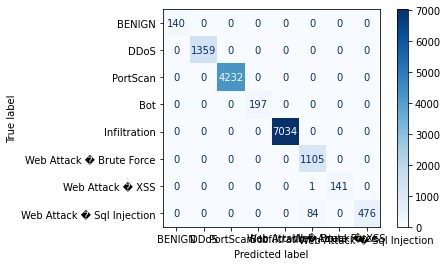

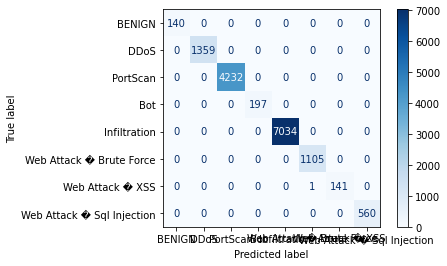

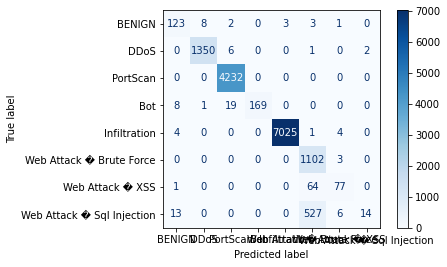

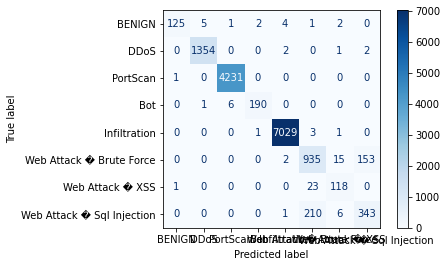

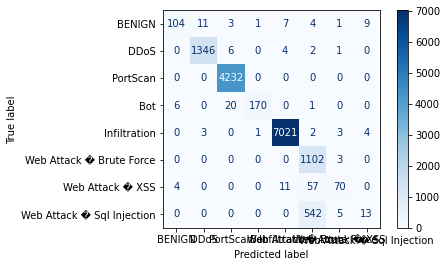

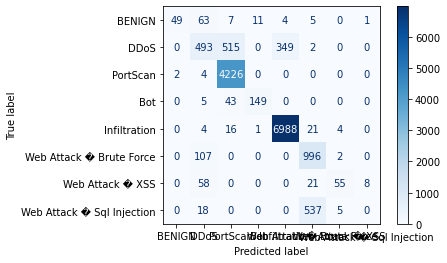

In [ ]:
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import time

models = []
models.append(('Random Forest Classifier', RFC_Classifier))
models.append(('Decision Tree Classifier', DTC_Classifier))
models.append(('Support Vector Classifier',SVM_Classifier))
models.append(('KNeighborsClassifier',KNN_Classifier))
models.append(('LogisticRegression',LGR_Classifier))
models.append(('Gaussian Naive Baye',BNB_Classifier))


for i, v in models:
    Xpred =  v.predict(X_train)
    scores = cross_val_score(v, X_train, Y_train, cv=10)
    accuracy = metrics.accuracy_score(Y_train, Xpred)
    confusion_matrix = metrics.confusion_matrix(Y_train, Xpred)
    cmd = metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=attackType)
    classification = metrics.classification_report(Y_train, Xpred)
    print()
    print('============================== {} Model Evaluation =============================='.format(i))
    print()
    print ("Cross Validation Mean Score:" "\n", scores.mean())
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()
    cmd.plot(cmap='Blues', include_values=True)
    time.sleep(1)

# Model Validation


============================== Random Forest Classifier Model Test Results ==============================

Model Accuracy:
 0.9603538145632602

Confusion matrix:
 [[  56    0    0    2    0    2    0    0]
 [   0  641    0    0    0    0    0    0]
 [   0    1 1767    0    0    0    0    0]
 [   0    1    1  101    0    0    0    0]
 [   0    0    0    1 2965    0    0    0]
 [   0    0    0    0    1  394    1   99]
 [   0    0    0    0    0    1   57    0]
 [   0    0    0    0    1  139    1   99]]

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.93      0.97        60
           1       1.00      1.00      1.00       641
           2       1.00      1.00      1.00      1768
           3       0.97      0.98      0.98       103
           4       1.00      1.00      1.00      2966
           5       0.74      0.80      0.76       495
           6       0.97      0.98      0.97        58
           7       0.50      0.41

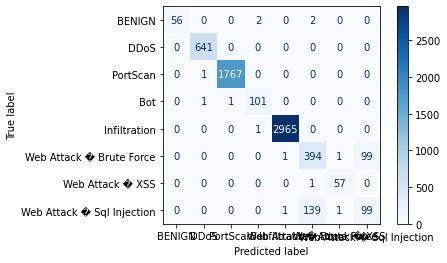

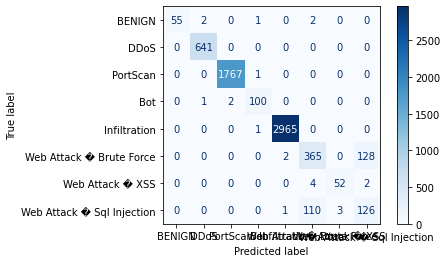

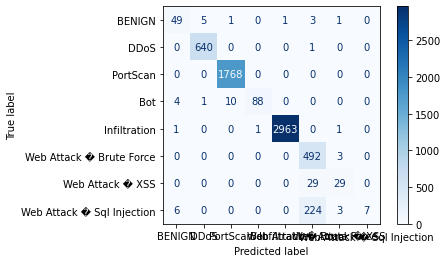

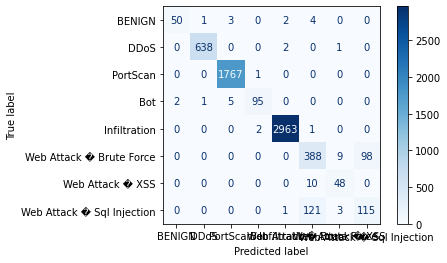

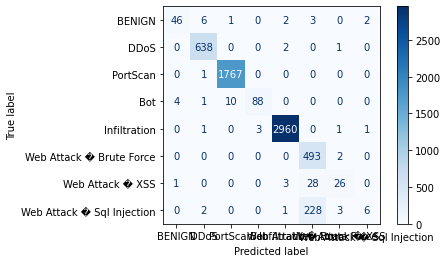

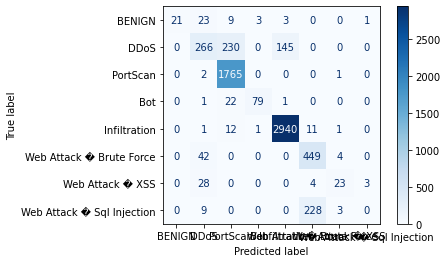

In [ ]:
for i, v in models:
    pred = v.predict(X_test)
    accuracy = metrics.accuracy_score(Y_test,pred)
    confusion_matrix = metrics.confusion_matrix(Y_test, pred)
    cmd = metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=attackType)
    classification = metrics.classification_report(Y_test, pred)
    print()
    print('============================== {} Model Test Results =============================='.format(i))
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()    
    cmd.plot(cmap='Blues', include_values=True)
    time.sleep(1)

# Ensemble Modelling 
## All the models used are combined using the VotingClassifier and the best results are obtained.


In [ ]:
from sklearn.ensemble import VotingClassifier

clf1 = tree.DecisionTreeClassifier(criterion='gini', max_depth=33, random_state=20, max_features=12, splitter='random')
clf2 = RandomForestClassifier(criterion='gini', max_depth=40, random_state=20)
clf3 = SVC()
clf4 = KNeighborsClassifier(n_jobs=-1)
clf5 = LogisticRegression(n_jobs=-1, random_state=0, max_iter=5000)
clf6 = BernoulliNB()

votingC = VotingClassifier(estimators=[('dc',clf1), ('rf', clf2),('svc',clf3),('knn',clf4),('lgr',clf5),('bnb',clf6)],voting='hard', weights=[2,2,1,2,1,1],flatten_transform=True)
votingC.fit(X_train,Y_train)

VotingClassifier(estimators=[('dc',
                              DecisionTreeClassifier(max_depth=33,
                                                     max_features=12,
                                                     random_state=20,
                                                     splitter='random')),
                             ('rf',
                              RandomForestClassifier(max_depth=40,
                                                     random_state=20)),
                             ('svc', SVC()),
                             ('knn', KNeighborsClassifier(n_jobs=-1)),
                             ('lgr',
                              LogisticRegression(max_iter=5000, n_jobs=-1,
                                                 random_state=0)),
                             ('bnb', BernoulliNB())],
                 weights=[2, 2, 1, 2, 1, 1])


============================== Voting Classifier Model Test Results ==============================

Model Accuracy:
 0.9606697204233139

Confusion matrix:
 [[  55    2    1    0    0    2    0    0]
 [   0  641    0    0    0    0    0    0]
 [   0    0 1768    0    0    0    0    0]
 [   1    1    5   96    0    0    0    0]
 [   0    0    0    1 2965    0    0    0]
 [   0    0    0    0    1  438    2   54]
 [   0    0    0    0    0   12   46    0]
 [   0    0    0    0    1  163    3   73]]

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.92      0.95        60
           1       1.00      1.00      1.00       641
           2       1.00      1.00      1.00      1768
           3       0.99      0.93      0.96       103
           4       1.00      1.00      1.00      2966
           5       0.71      0.88      0.79       495
           6       0.90      0.79      0.84        58
           7       0.57      0.30      0

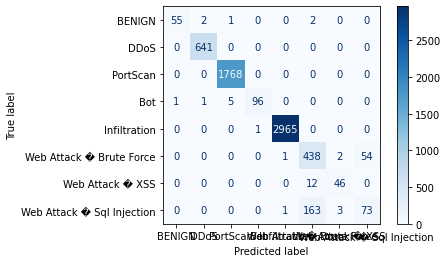

In [ ]:
pred = votingC.predict(X_test)
accuracy = metrics.accuracy_score(Y_test,pred)
confusion_matrix = metrics.confusion_matrix(Y_test, pred)
cmd = metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=attackType)
classification = metrics.classification_report(Y_test, pred)
print()
print('============================== {} Model Test Results =============================='.format('Voting Classifier'))
print()
print ("Model Accuracy:" "\n", accuracy)
print()
print("Confusion matrix:" "\n", confusion_matrix)
print()
print("Classification report:" "\n", classification) 
print()    
cmd.plot(cmap='Blues', include_values=True)
time.sleep(1)